In [1]:
import pickle
import os
import time
import numpy as np
import ast

import pandas as pd
import warnings
import h5py 
import glob

#from scorefunctions import *
import matplotlib.pyplot as plt
import sys
import seaborn as sns


from scipy import ndimage

import matplotlib.ticker as ticker

### loading data

In [2]:
directory='/project/fudenber_735/polychrom/Dynamic_boundary_model/1d_sims_dynamic_boundary/dynamical_boundary_simulations/sims/'

In [3]:
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')
file

,lifetime,velocity,clife,cof,sep,fripscore
0,1000.0,1,10.0,1.0,100,0.032043
1,1500.0,1,10.0,1.0,100,0.036549
2,500.0,1,10.0,1.0,100,0.035532
3,1000.0,1,10.0,10.0,100,0.021623
4,1500.0,1,10.0,10.0,100,0.018044
...,...,...,...,...,...,...
5707,1500.0,1,5000.0,933.0,100,0.549357
5708,500.0,1,5000.0,933.0,100,0.372003
5709,1000.0,1,5000.0,9333.0,100,0.283509
5710,1500.0,1,5000.0,9333.0,100,0.314900


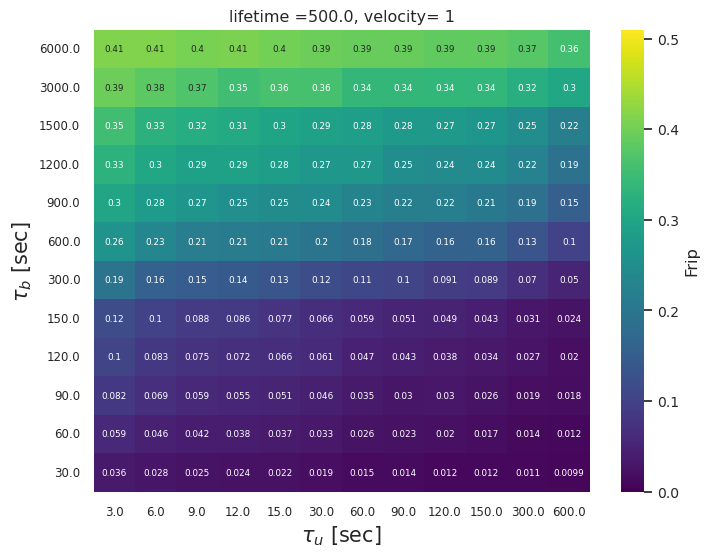

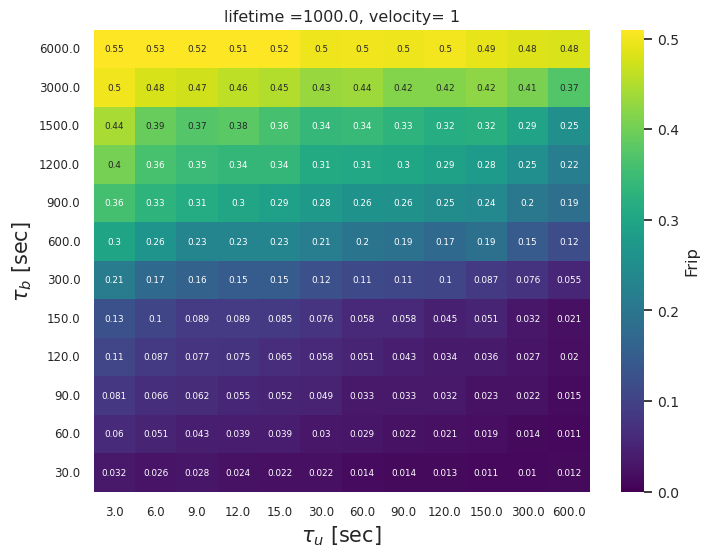

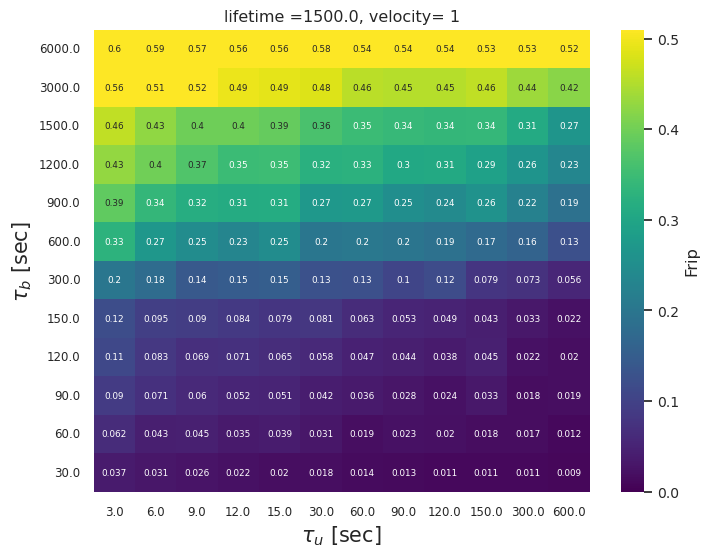

In [30]:
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')
file

#file = file[(file[' clife']<=1500)&(file[' clife']>4.5)&(file[' cof']>0.3)&(file[' cof']<=150)&(file['lifetime']>300)
#            &(file[' clife']!=50)&(file[' cof']!=5)]
convertor = 25*60/500
file[' clife']=file[' clife']*convertor
file[' cof']=file[' cof']*convertor
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']

file_100 = file[file['sep']==100.0]

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
#list_cof = [3, 9, 
clife_list = [ 30.0, 60.0, 90.0, 120.0, 150.0, 300.0, 600, 900, 1200, 1500, 3000, 6000]
#unique_life = clife_list
cof_list = [3, 6, 9, 12, 15, 30, 60, 90, 120, 150, 300, 600]
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file_100[(lifetime == life)&(velocity == vel) ][[' clife',' cof',' fripscore']]
        new_file = new_file[new_file[' clife'].isin(clife_list)]
        new_file = new_file[new_file[' cof'].isin(cof_list)]
        #print(new_file)
        #new_file_filtered = new_file.drop_duplicates(keep = 'first')
        #new_file = new_file[new_file[' clife'] in clife_list]
        new_file_filtered = new_file
        heatmap_data = new_file_filtered.pivot(' clife', ' cof', ' fripscore')
        
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0.0,vmax=0.51, cbar_kws={'label': 'Frip score'} )
        sns.set(font_scale=0.531)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Frip', fontsize=11.75)
        # Customize 
        plt.xlabel(r'$\tau_u$ [sec]', fontsize = 15)
        plt.xticks(fontsize =8.5)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =15)
        plt.yticks(fontsize = 8.5, rotation=0)
        plt.title('lifetime =%s, velocity= %s'%(life, vel), fontsize = 11.5)
        plt.gca().invert_yaxis()
        plt.savefig('../../images/fripsweep_for_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

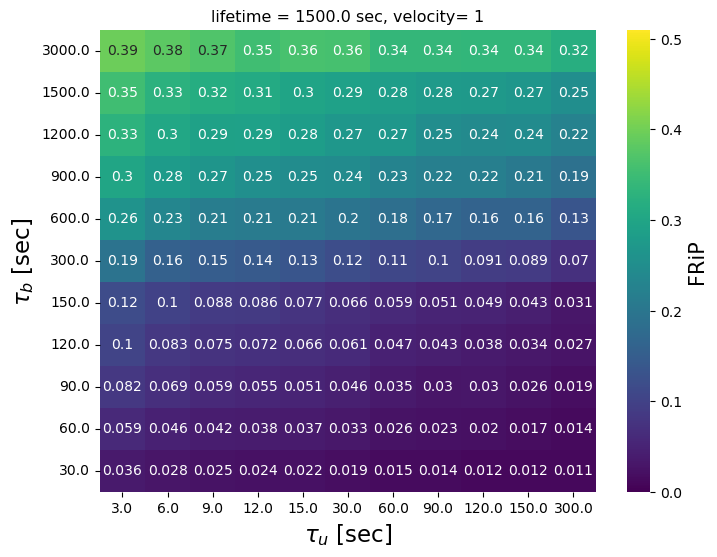

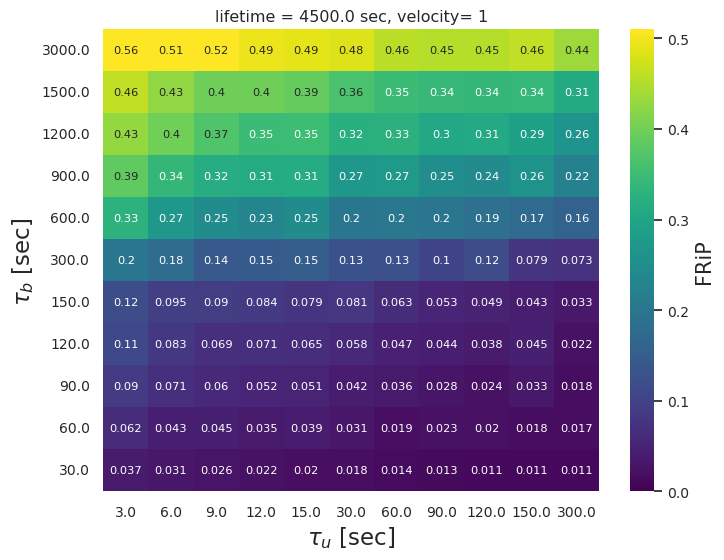

In [4]:
from scipy import ndimage

# Read the data
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')
#file = pd.read_csv('../../python_codes_calculations/data/frip/fripscore.csv')

# Filter the data
#file = file[(file[' clife'] <= 1500) & (file[' clife'] > 4.5) & (file[' cof'] > 0.3) & (file[' cof'] <= 150) &
#            (file['lifetime'] > 300) & (file[' clife'] != 50) & (file[' cof'] != 5)]
convertor = 25 * 60 / 500
file[' clife'] = file[' clife'] * convertor
file[' cof'] = file[' cof'] * convertor
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']

file_100 = file[file['sep'] == 100.0]

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

unique_life = [500, 1500]
unique_vel = [1]
clife_list = [ 30.0, 60.0, 90.0, 120.0, 150.0, 300.0, 600, 900, 1200, 1500, 3000]
#unique_life = clife_list
cof_list = [3, 6, 9, 12, 15, 30, 60, 90, 120, 150, 300]
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file_100[(lifetime == life) & (velocity == vel)][[' clife', ' cof', ' fripscore']]
        new_file = new_file[new_file[' clife'].isin(clife_list)]
        new_file = new_file[new_file[' cof'].isin(cof_list)]
        #new_file_filtered = new_file.drop_duplicates(keep='first')
        new_file_filtered = new_file
        heatmap_data = new_file_filtered.pivot(' clife', ' cof', ' fripscore')
        
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0.0, vmax=0.51, cbar_kws={'label': 'Frip score'})
        sns.set(font_scale=0.681)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('FRiP', fontsize=15)
        
        
        plt.xlabel(r'$\tau_u$ [sec]', fontsize=16.5)
        plt.xticks(fontsize=10)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize=16.5)
        plt.yticks(fontsize=10, rotation=0)
        plt.title('lifetime = %s sec, velocity= %s' % (life * convertor, vel), fontsize=11.5)
        plt.gca().invert_yaxis()
        
        # Add legend
        #plt.legend(handles=[hansen_line, Liu_line, occupancy_line], loc=(1.195,0.81), fontsize =11.5)
        
        plt.savefig('fripsweep_for_%s_%s.pdf' % (life, vel), transparent=True, bbox_inches='tight')
        plt.show()


In [5]:
more_file_filtered=new_file_filtered
more_file_filtered[' occup']=more_file_filtered[' clife']/(more_file_filtered[' clife']+more_file_filtered[' cof'])
more_file_filtered=more_file_filtered[[' clife',' cof',' occup']]
more_file_filtered

,clife,cof,occup
1,30.0,3.0,0.909091
4,30.0,30.0,0.500000
7,30.0,300.0,0.090909
106,30.0,6.0,0.833333
109,30.0,60.0,0.333333
...,...,...,...
5176,1500.0,90.0,0.943396
5203,1500.0,12.0,0.992063
5206,1500.0,120.0,0.925926
5254,1500.0,15.0,0.990099


11
11


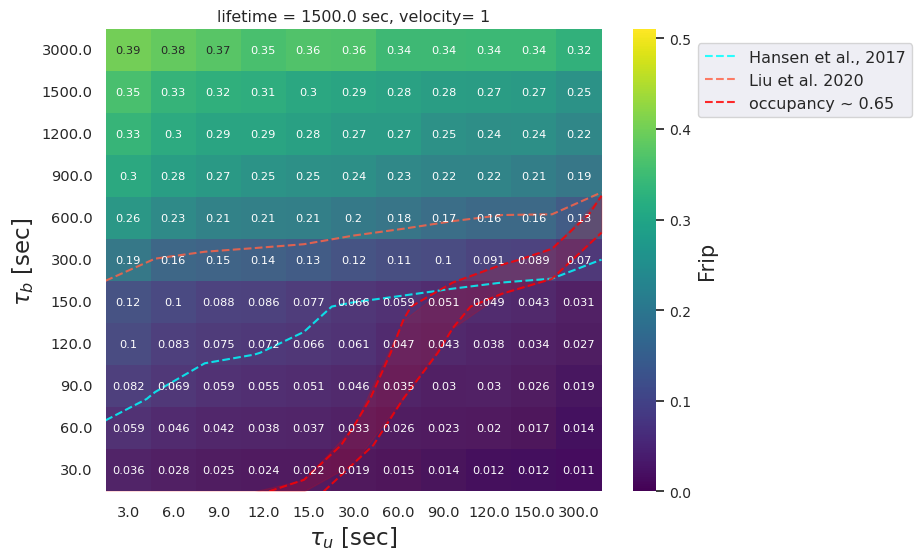

In [7]:
from scipy import ndimage

# Read the data
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')
#file = pd.read_csv('../../python_codes_calculations/data/frip/fripscore.csv')

# Filter the data
#file = file[(file[' clife'] <= 1500) & (file[' clife'] > 4.5) & (file[' cof'] > 0.3) & (file[' cof'] <= 150) &
#            (file['lifetime'] > 300) & (file[' clife'] != 50) & (file[' cof'] != 5)]
convertor = 25 * 60 / 500
file[' clife'] = file[' clife'] * convertor
file[' cof'] = file[' cof'] * convertor
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']

file_100 = file[file['sep'] == 100.0]

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

unique_life = [500]
unique_vel = [1]
clife_list = [ 30.0, 60.0, 90.0, 120.0, 150.0, 300.0, 600, 900, 1200, 1500, 3000]
#unique_life = clife_list
cof_list = [3, 6, 9, 12, 15, 30, 60, 90, 120, 150, 300]
for life in list(unique_life):
    for vel in list(unique_vel):
        new_file = file_100[(lifetime == life) & (velocity == vel)][[' clife', ' cof', ' fripscore']]
        new_file = new_file[new_file[' clife'].isin(clife_list)]
        new_file = new_file[new_file[' cof'].isin(cof_list)]
        #new_file_filtered = new_file.drop_duplicates(keep='first')
        new_file_filtered = new_file
        print(len(np.unique(new_file[' clife'])))
        print(len(np.unique(new_file[' cof'])))
        heatmap_data = new_file_filtered.pivot(' clife', ' cof', ' fripscore')
        
        smooth_scale = 1
        z = ndimage.zoom(heatmap_data.to_numpy(), smooth_scale)
        
        # Create the heatmap using seaborn
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0.0, vmax=0.51, cbar_kws={'label': 'Frip score'})
        sns.set(font_scale=0.681)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=10)
        cbar.set_label('Frip', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        cntr1 = im.contour(np.linspace(0, 11, 11 * smooth_scale),
                           np.linspace(0, 11, 11 * smooth_scale),
                           heatmap_data.to_numpy(), levels=[0.071], colors='cyan', linestyles='dashed', alpha=0.83)
        
        cntr3 = im.contour(np.linspace(0, 11, 11 * smooth_scale),
                           np.linspace(0, 11, 11 * smooth_scale),
                           heatmap_data.to_numpy(), levels=[0.16], colors='tomato', linestyles='dashed', alpha=0.83)
        
        x_cntr1 = np.linspace(0, 11, 11 * smooth_scale)
        y_cntr1 = np.interp(x_cntr1, cntr1.collections[0].get_paths()[0].vertices[:, 0],
                            cntr1.collections[0].get_paths()[0].vertices[:, 1])
        
        x_cntr3 = np.linspace(0, 11, 11 * smooth_scale)
        y_cntr3 = np.interp(x_cntr3, cntr3.collections[0].get_paths()[0].vertices[:, 0],
                            cntr3.collections[0].get_paths()[0].vertices[:, 1])
        
        # Add legend manually for the contours
        hansen_line, = plt.plot([], [], color='cyan', linestyle='dashed', alpha=0.83, label='Hansen et al., 2017')
        Liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al. 2020')
        
        ### occupancy exp det
        new_heatmap_data = more_file_filtered.pivot(' clife', ' cof', ' occup')
        
        smooth_scale = 1
        z = ndimage.zoom(new_heatmap_data.to_numpy(), smooth_scale)
        
        new_im = sns.heatmap(new_heatmap_data, annot=False, cmap='viridis', alpha=0.05, vmin=0.0, vmax=0.3, cbar=None)

        cntr1 = new_im.contour(np.linspace(0, 11, 11 * smooth_scale),
                               np.linspace(0, 11, 11 * smooth_scale),
                               new_heatmap_data.to_numpy(), levels=[0.6], colors='red', linestyles='dashed', alpha=0.83)
        
        cntr3 = new_im.contour(np.linspace(0, 11, 11 * smooth_scale),
                               np.linspace(0, 11, 11 * smooth_scale),
                               new_heatmap_data.to_numpy(), levels=[0.7], colors='red', linestyles='dashed', alpha=0.83)
        occupancy_line, = plt.plot([], [], color='red', linestyle='dashed', alpha=0.83, label='occupancy ~ 0.65')
        
        x_cntr1 = np.linspace(0, 11, 11 * smooth_scale)
        y_cntr1 = np.interp(x_cntr1, cntr1.collections[0].get_paths()[0].vertices[:, 0],
                            cntr1.collections[0].get_paths()[0].vertices[:, 1])
        
        x_cntr3 = np.linspace(0, 11, 11 * smooth_scale)
        y_cntr3 = np.interp(x_cntr3, cntr3.collections[0].get_paths()[0].vertices[:, 0],
                            cntr3.collections[0].get_paths()[0].vertices[:, 1])
        
        plt.fill_between(x_cntr1, y_cntr1, y_cntr3, color='red', alpha=0.15)
        
        plt.xlabel(r'$\tau_u$ [sec]', fontsize=16.5)
        plt.xticks(fontsize=10.5)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize=16.5)
        plt.yticks(fontsize=10.5, rotation=0)
        plt.title('lifetime = %s sec, velocity= %s' % (life * convertor, vel), fontsize=11.5)
        plt.gca().invert_yaxis()
        
        # Add legend
        plt.legend(handles=[hansen_line, Liu_line, occupancy_line], loc=(1.195,0.81), fontsize =11.5)
        
        plt.savefig('fripsweep_for_%s_%s_estimated_exp.pdf' % (life, vel), transparent=True, bbox_inches='tight')
        plt.show()


### FRiP at higher separations

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


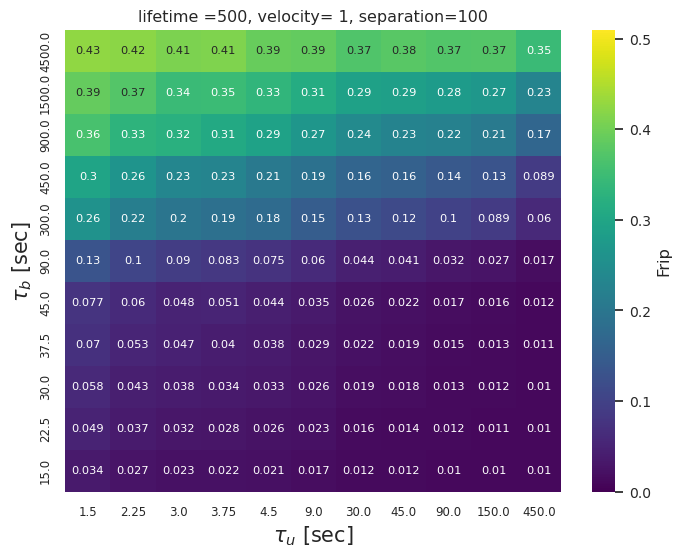

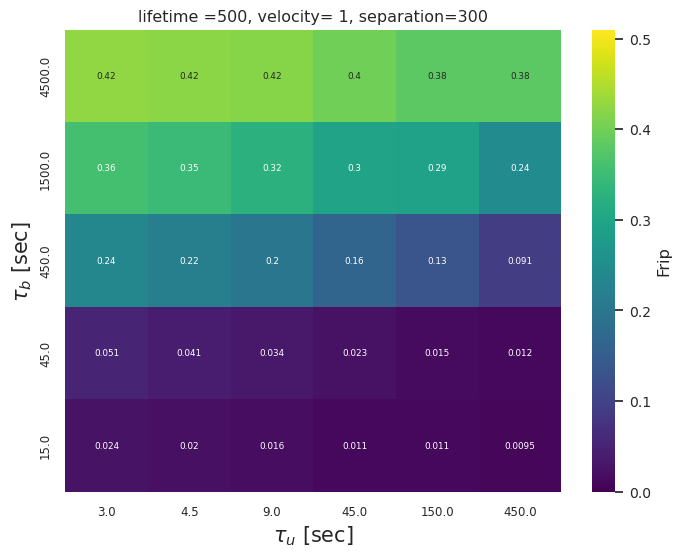

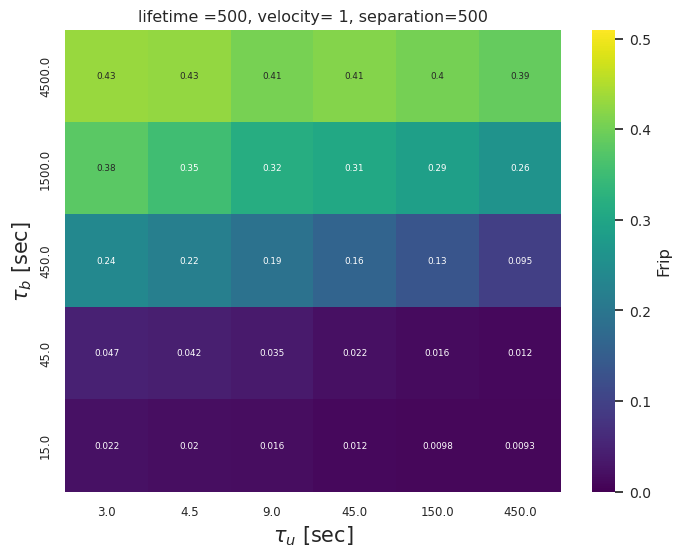

In [8]:
file = pd.read_csv('../../python_codes_calculations/data/frip/fripscore.csv')
file

file = file[(file[' clife']<=1500)&(file[' clife']>4.5)&(file[' cof']>0.3)&(file[' cof']<=150)&(file['lifetime']>300)
            &(file[' clife']!=50)&(file[' cof']!=5)]
convertor = 25*60/500
file[' clife']=file[' clife']*convertor
file[' cof']=file[' cof']*convertor
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']

unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)

unique_vel=[1]
unique_life=[500]
unique_sep = [100, 300, 500]
for life in list(unique_life):
    for vel in list(unique_vel):
        for sep in list(unique_sep):
            file_s = file[file['sep']==sep]
            new_file = file_s[(lifetime == life)&(velocity == vel) ][[' clife',' cof',' fripscore']]
            
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            
            heatmap_data = new_file_filtered.pivot(' clife', ' cof', ' fripscore')
            
            
            # Create the heatmap using seaborn
            plt.figure(figsize=(8, 6))
            im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0.0,vmax=0.51, cbar_kws={'label': 'Frip score'} )
            sns.set(font_scale=0.531)
            cbar = im.collections[0].colorbar
            cbar.ax.tick_params(labelsize=10)
            cbar.set_label('Frip', fontsize=11.75)
            # Customize 
            plt.xlabel(r'$\tau_u$ [sec]', fontsize = 15)
            plt.xticks(fontsize =8.5)
            plt.ylabel(r'$\tau_b$ [sec]', fontsize =15)
            plt.yticks(fontsize = 8.5)
            plt.title('lifetime =%s, velocity= %s, separation=%s'%(life, vel, sep), fontsize = 11.5)
            plt.gca().invert_yaxis()
            #plt.savefig('../images/fripsweep_for_%s_%s.png'%(life, vel), transparent = True, bbox_inches = 'tight')
            plt.show()

### heat maps of Frip and occupancy rate

In [10]:
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')


#file = file[file[' cof']>=0.3]
#file = file[file[' clife']>3]
file ['occupancy']=(file[' clife']/(file[' clife']+file[' cof'])).round(2)
file = file[file['occupancy']<=0.915]
file


,lifetime,velocity,clife,cof,sep,fripscore,occupancy
0,1000.0,1,10.0,1.0,100,0.032043,0.91
1,1500.0,1,10.0,1.0,100,0.036549,0.91
2,500.0,1,10.0,1.0,100,0.035532,0.91
3,1000.0,1,10.0,10.0,100,0.021623,0.50
4,1500.0,1,10.0,10.0,100,0.018044,0.50
...,...,...,...,...,...,...,...
5707,1500.0,1,5000.0,933.0,100,0.549357,0.84
5708,500.0,1,5000.0,933.0,100,0.372003,0.84
5709,1000.0,1,5000.0,9333.0,100,0.283509,0.35
5710,1500.0,1,5000.0,9333.0,100,0.314900,0.35


In [11]:
aimed_occupancy = [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

occup_list = []
for occups in np.unique(file['occupancy']):
    for occup_a in aimed_occupancy:
        if np.abs(occups-occup_a) <= 0.03:
            occup_list.append(occups)

In [12]:
new_file = file[file['occupancy'].isin(occup_list)]
new_file

,lifetime,velocity,clife,cof,sep,fripscore,occupancy
0,1000.0,1,10.0,1.0,100,0.032043,0.91
1,1500.0,1,10.0,1.0,100,0.036549,0.91
2,500.0,1,10.0,1.0,100,0.035532,0.91
3,1000.0,1,10.0,10.0,100,0.021623,0.50
4,1500.0,1,10.0,10.0,100,0.018044,0.50
...,...,...,...,...,...,...,...
5668,1500.0,1,5000.0,7500.0,100,0.359420,0.40
5669,500.0,1,5000.0,7500.0,100,0.207584,0.40
5679,1000.0,1,5000.0,8000.0,100,0.304976,0.38
5680,1500.0,1,5000.0,8000.0,100,0.316561,0.38


In [13]:
new_file['occupancy']=np.round(new_file['occupancy'],1)
new_file

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,lifetime,velocity,clife,cof,sep,fripscore,occupancy
0,1000.0,1,10.0,1.0,100,0.032043,0.9
1,1500.0,1,10.0,1.0,100,0.036549,0.9
2,500.0,1,10.0,1.0,100,0.035532,0.9
3,1000.0,1,10.0,10.0,100,0.021623,0.5
4,1500.0,1,10.0,10.0,100,0.018044,0.5
...,...,...,...,...,...,...,...
5668,1500.0,1,5000.0,7500.0,100,0.359420,0.4
5669,500.0,1,5000.0,7500.0,100,0.207584,0.4
5679,1000.0,1,5000.0,8000.0,100,0.304976,0.4
5680,1500.0,1,5000.0,8000.0,100,0.316561,0.4


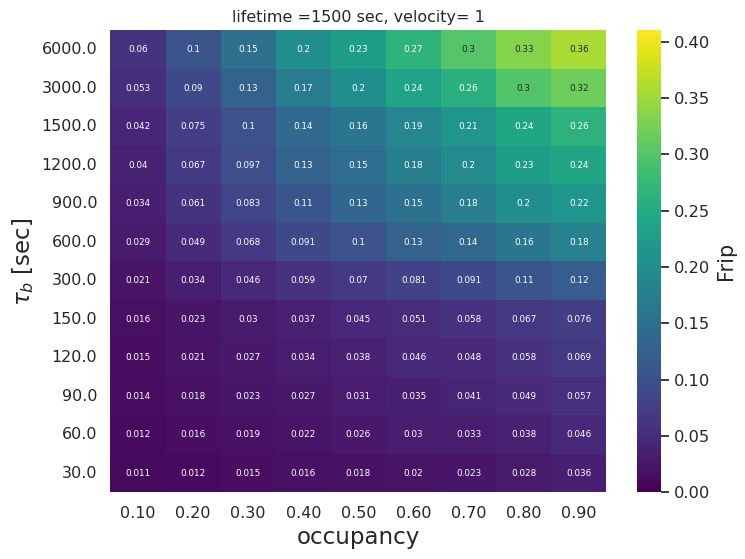

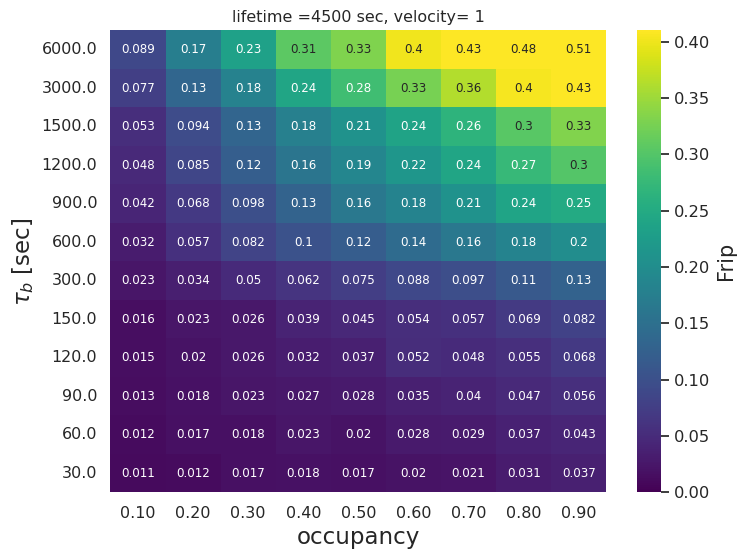

In [17]:
list_life, list_vel = [500, 1500], [1]
for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = new_file[(new_file['lifetime'] == life)&(new_file[' velocity'] == vel) ][[' clife','occupancy',' fripscore']]

        #new_file_filtered_unique = new_file_filtere
        #new_file_filtered_unique['occupancy_bin'] = pd.cut(new_file_filtered_unique['occupancy'], bins=bins, labels=labels, right=False)
    
        dtaframe = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
        new_file_filtered_unique = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
        # Remove any NaN values
        new_file_filtered_unique = new_file_filtered_unique.dropna()
        
        # Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
        dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()
        convertor = 3
        dtaframe_grouped [' clife']= dtaframe_grouped[' clife']*convertor
        dtaframe_grouped=dtaframe_grouped[dtaframe_grouped[' clife']<=6000]
        heatmap_data = dtaframe_grouped.pivot(' clife', 'occupancy', ' fripscore')
                
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0.0,vmax=0.41, cbar_kws={'label': 'Frip score'} )
        sns.set(font_scale=0.71)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('Frip', fontsize=15)
        
        im.set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        ytick_labels = [int(float(t.get_text())) for t in im.get_yticklabels()]
        plt.xlabel(r'occupancy', fontsize = 16.5)
        plt.xticks(fontsize =11.5, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11.5, rotation = 0)
        plt.title('lifetime =%s sec, velocity= %s'%(life*convertor, vel), fontsize = 11.5)
        plt.gca().invert_yaxis()
        plt.savefig('fripsweep_for_occupancy_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

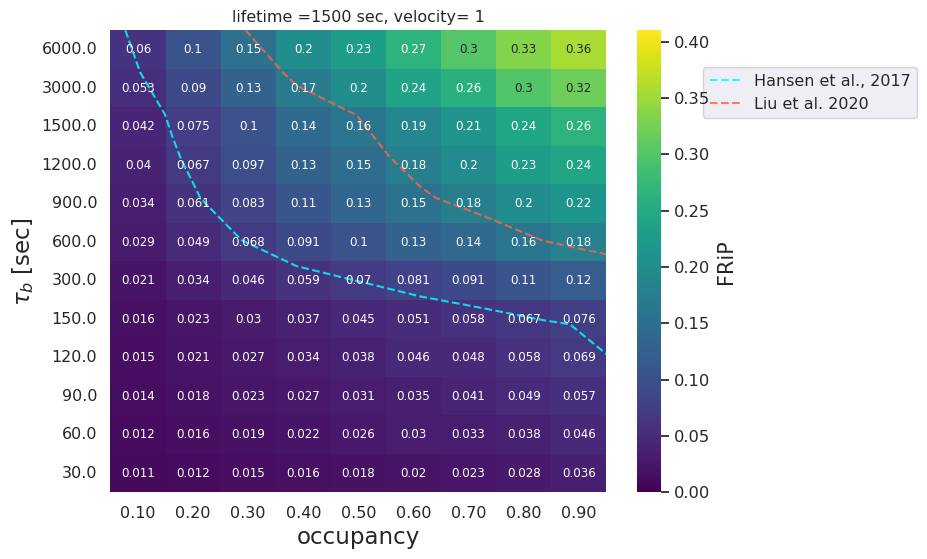

In [19]:
list_life, list_vel = [500], [1]

numline_c = 12
numline_o =9
for life in list(list_life):
    for vel in list(list_vel):
        new_file_filtered_unique = new_file[(new_file['lifetime'] == life)&(new_file[' velocity'] == vel) ][[' clife','occupancy',' fripscore']]

        #new_file_filtered_unique = new_file_filtere
        #new_file_filtered_unique['occupancy_bin'] = pd.cut(new_file_filtered_unique['occupancy'], bins=bins, labels=labels, right=False)
    
        dtaframe = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
        new_file_filtered_unique = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
        # Remove any NaN values
        new_file_filtered_unique = new_file_filtered_unique.dropna()
        
        # Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
        dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()
        convertor = 3
        dtaframe_grouped [' clife']= dtaframe_grouped[' clife']*convertor
        dtaframe_grouped=dtaframe_grouped[dtaframe_grouped[' clife']<=6000]
        heatmap_data = dtaframe_grouped.pivot(' clife', 'occupancy', ' fripscore')
                
        plt.figure(figsize=(8, 6))
        im = sns.heatmap(heatmap_data, annot=True, cmap='viridis', vmin=0.0,vmax=0.41, cbar_kws={'label': 'Frip score'} )
        sns.set(font_scale=0.831)
        cbar = im.collections[0].colorbar
        cbar.ax.tick_params(labelsize=11.75)
        cbar.set_label('FRiP', fontsize=15)
        
        # Add equipotential lines for loop size = 700
        smooth_scale = 1
        z = ndimage.zoom(new_heatmap_data.to_numpy(), smooth_scale)
        cntr1 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           heatmap_data.to_numpy(), levels=[0.071], colors='cyan', linestyles='dashed', alpha=0.83)
        
        cntr3 = im.contour(np.linspace(0, numline_o, numline_o * smooth_scale),
                           np.linspace(0, numline_c, numline_c * smooth_scale),
                           heatmap_data.to_numpy(), levels=[0.16], colors='tomato', linestyles='dashed', alpha=0.83)
        
        #x_cntr1 = np.linspace(0, 11, 11 * smooth_scale)
       # y_cntr1 = np.interp(x_cntr1, cntr1.collections[0].get_paths()[0].vertices[:, 0],
        #                    cntr1.collections[0].get_paths()[0].vertices[:, 1])
        
        #x_cntr3 = np.linspace(0, 11, 11 * smooth_scale)
        #y_cntr3 = np.interp(x_cntr3, cntr3.collections[0].get_paths()[0].vertices[:, 0],
        #                    cntr3.collections[0].get_paths()[0].vertices[:, 1])
        
        # Add legend manually for the contours
        hansen_line, = plt.plot([], [], color='cyan', linestyle='dashed', alpha=0.83, label='Hansen et al., 2017')
        Liu_line, = plt.plot([], [], color='tomato', linestyle='dashed', alpha=0.83, label='Liu et al. 2020')
        
        
        im.set_xticklabels(['{:.2f}'.format(float(t.get_text())) for t in im.get_xticklabels()])
        ytick_labels = [int(float(t.get_text())) for t in im.get_yticklabels()]
        plt.xlabel(r'occupancy', fontsize = 16.5)
        plt.xticks(fontsize =11.5, rotation=0)
        plt.ylabel(r'$\tau_b$ [sec]', fontsize =16.5)
        plt.yticks(fontsize = 11.5, rotation = 0)
        plt.title('lifetime =%s sec, velocity= %s'%(life*convertor, vel), fontsize = 11.5)
        # Add legend
        plt.legend(handles=[hansen_line, Liu_line], loc=(1.195,0.81), fontsize =11.5)
        plt.gca().invert_yaxis()
        plt.savefig('fripsweep_for_occupancy_%s_%s.pdf'%(life, vel), transparent = True, bbox_inches = 'tight')
        plt.show()

In [20]:
num_plot =10
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()
sns.reset_defaults()

In [203]:
aimed_occupancy = [0.1, 0.2,0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

occup_list = []
for occups in np.unique(file['occupancy']):
    for occup_a in aimed_occupancy:
        if np.abs(occups-occup_a) <= 0.0115:
            occup_list.append(occups)

In [204]:
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')


#file = file[file[' cof']>=0.3]
#file = file[file['occupancy']<=0.915]
#file = file[file[' clife']>3]
file ['occupancy']=(file[' clife']/(file[' clife']+file[' cof'])).round(2)
file
new_file = file[file['occupancy'].isin(occup_list)]
new_file['occupancy']=np.round(new_file['occupancy'],1)
new_file

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,lifetime,velocity,clife,cof,sep,fripscore,occupancy
0,1000.0,1,10.0,1.0,100,0.032043,0.9
1,1500.0,1,10.0,1.0,100,0.036549,0.9
2,500.0,1,10.0,1.0,100,0.035532,0.9
3,1000.0,1,10.0,10.0,100,0.021623,0.5
4,1500.0,1,10.0,10.0,100,0.018044,0.5
...,...,...,...,...,...,...,...
5635,1500.0,1,5000.0,600.0,100,0.570988,0.9
5636,500.0,1,5000.0,600.0,100,0.393432,0.9
5667,1000.0,1,5000.0,7500.0,100,0.298579,0.4
5668,1500.0,1,5000.0,7500.0,100,0.359420,0.4


In [205]:
np.max(new_file[' clife'])

10000.0

In [206]:
list_occup=np.unique(new_file['occupancy'])
list_occup

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [207]:
new_file_filtered_unique = new_file[(lifetime == life)&(velocity == vel) ][[' clife','occupancy',' fripscore']]
        
#dtaframe = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
#new_file_filtered_unique = new_file_filtered_unique[[' clife', 'occupancy', ' fripscore']]
# Remove any NaN values
new_file_filtered_unique = new_file_filtered_unique.dropna()

# Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()
dtaframe_grouped

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,clife,occupancy,fripscore
0,10.0,0.1,0.011178
1,10.0,0.2,0.012169
2,10.0,0.3,0.014785
3,10.0,0.4,0.015874
4,10.0,0.5,0.019348
...,...,...,...
138,10000.0,0.5,0.251563
139,10000.0,0.6,0.293323
140,10000.0,0.7,0.334860
141,10000.0,0.8,0.370493


In [208]:
num_plot =7
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
colors=list(colors)
colors.reverse()
sns.reset_defaults()

In [209]:
np.min(new_file[' clife'])

10.0

/home1/rahmanin/.conda/envs/openmm-env/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


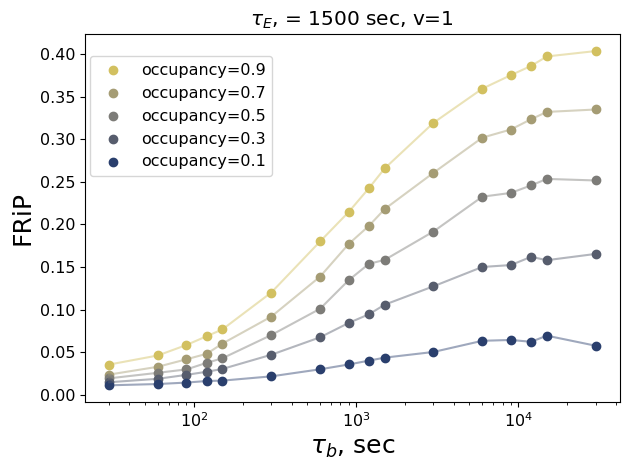

In [214]:
lifes, vels = [500] , [1]

#occupancy=file[' occupancy']
list_occup = [ 0.9,  0.7,  0.5, 0.3, 0.1]
convertor = 25*60/500

i=1
sns.reset_defaults()
#list_occup = np.unique(dtaframe_grouped['occupancy_bin'])
for life in lifes:
    for vel in vels:
        for occup in list_occup[:]:
            new_file_filtered_unique = new_file[(lifetime == life)&(velocity == vel) ][[' clife','occupancy',' fripscore']]
        
            new_file_filtered_unique = new_file_filtered_unique.dropna()
            
            # Group by ' clife' and 'occupancy_bin', and calculate the mean of ' fripscore'
            dtaframe_grouped = new_file_filtered_unique.groupby([' clife', 'occupancy'], as_index=False).mean()
            convertor = 3
            dtaframe_grouped [' clife']= dtaframe_grouped[' clife']*convertor
            #dtaframe_grouped=dtaframe_grouped[dtaframe_grouped[' clife']<=6000]
            #file = dtaframe_grouped
            dtaframe_grouped = dtaframe_grouped[dtaframe_grouped['occupancy']==occup]
            dtaframe_grouped = dtaframe_grouped[[' clife', ' fripscore']]
            #print('occupancy is %s'%occup,new_file)
            new_file_filtered = dtaframe_grouped.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values(' clife')
            new_clife = new_file_filtered[' clife']
            #print(np.min(new_clife))
            #print(np.max(new_clife))
            frip_score = new_file_filtered[' fripscore']
            plt.scatter(new_clife[:], frip_score[:], color=colors[i],label=r'occupancy=%s'%(occup))
            plt.plot(new_clife[:], frip_score[:], color=colors[i],alpha = 0.45)
            i+=1

life_w = 500*convertor
delta = 300*convertor
#plt.plot([life_w, life_w, life_w],[0,0.3,0.431],'--', color = 'red',alpha = 0.75, linewidth = 0.75, label = r'$\tau$=$\tau^W_E$')
#plt.plot([life_w-delta, life_w-delta, life_w-delta],[0,0.3,0.431],'--', color = 'blue',
#         alpha = 0.75, linewidth = 0.75, label = r'$\tau$$\sim$$\tau^W_E-\delta$')
plt.xlim()
plt.title(r'$\tau_E$, = %s sec, v=1'%(life*convertor),fontsize=14.5)
plt.xscale('log')
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize = 11.51,loc = (0.01,0.615))
plt.ylabel('FRiP',fontsize = 18)
plt.xlabel(r'$\tau_b$, sec', fontsize = 18)
plt.tight_layout()
plt.savefig('frip_for_tau.pdf',transparent=True)

plt.show()
        

In [157]:
ctcfrightlist = [314, 579, 1195, 3717, 3772, 3921, 4451, 5193, 5723, 6302, 6574, 6779, 7000, 9232, 9310, 9861]
ctcfleftlist = [495, 865, 1404, 2164, 3143, 3615, 3971, 4069, 4480, 4938, 5300, 5587, 6401, 7725, 8764, 9619]

<function seaborn.rcmod.reset_defaults()>

In [21]:
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')
file

,lifetime,velocity,clife,cof,sep,fripscore
0,1000.0,1,10.0,1.0,100,0.032043
1,1500.0,1,10.0,1.0,100,0.036549
2,500.0,1,10.0,1.0,100,0.035532
3,1000.0,1,10.0,10.0,100,0.021623
4,1500.0,1,10.0,10.0,100,0.018044
...,...,...,...,...,...,...
5707,1500.0,1,5000.0,933.0,100,0.549357
5708,500.0,1,5000.0,933.0,100,0.372003
5709,1000.0,1,5000.0,9333.0,100,0.283509
5710,1500.0,1,5000.0,9333.0,100,0.314900


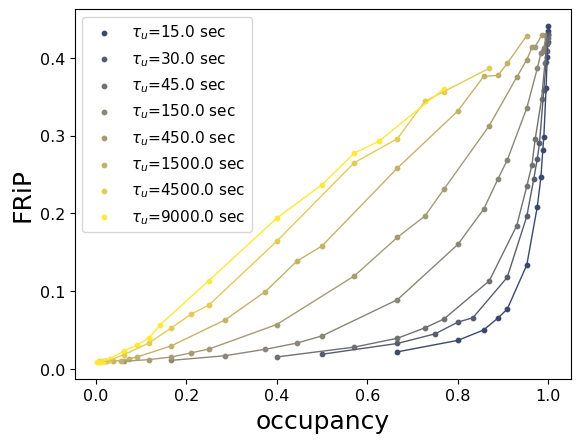

In [27]:
lifes, vels = [500] , [1]


i=1
num_plot = 10
viridis_cmap = plt.get_cmap('cividis')

# Generate an array of values from 0 to 1 to map to colors in the colormap
values = np.linspace(0, 1, num_plot)

# Get the corresponding colors from the colormap
colors = viridis_cmap(values)
convertor = 25*60/500
file = pd.read_csv('../../python_codes_calculations/data/fripscore_hres.csv')
file = file[file['sep']==100]
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']
unique_life = np.unique(lifetime)
unique_vel = np.unique(velocity)
unique_clife = np.unique(clife)
unique_cof = np.unique(cof)
cof_val = 10
list_cof =[5, 10,  15, 50, 150, 500,1500, 3000]
for cof_val in list_cof:
    for life in lifes:
        for vel in vels:
            i+=1
            new_file = file[(lifetime == life)&(velocity == vel)&(cof==cof_val)][[' clife',' cof', ' fripscore']]
            new_file_filtered = new_file.drop_duplicates(keep = 'first')
            new_file_filtered = new_file_filtered.sort_values(' clife')
            new_clife = new_file_filtered[' clife']
            frip_score = new_file_filtered[' fripscore']
            plt.scatter(new_clife/(new_clife+cof_val), frip_score, label = r'$\tau_u$=%s sec'%(cof_val*convertor),linewidth=1,s=10, color = colors[i])
            plt.plot(new_clife/(new_clife+cof_val), frip_score, linewidth=1, color = colors[i])


lifes, vels = [500] , [1]
file = pd.read_csv('../../data/fripscore_static.csv')
frip_score = file[' fripscore']
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']
face = file[' face']
cof_val = 1
clife_val = 10
for life in lifes:
    for vel in vels:
        new_file_stat = file[(lifetime == life)&(velocity == vel)&(cof==cof_val)&(clife==clife_val)][[' face', ' fripscore']]
        new_file_filtered = new_file_stat.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values(' face')
        new_face = new_file_filtered[' face']
        frip_score = new_file_filtered[' fripscore']
        #plt.plot(new_face, frip_score, color='blue',linestyle='--', linewidth =1, label ='static')

lifes, vels = [500] , [1]
file = pd.read_csv('../../data/fripscore_static_pause_with_number.csv')
file = file[(file['lifetime']==500)&(file[' velocity']==1)&(file[' separation']==100)]
seps = np.unique(file[' face'])
frip_score = file[' fripscore']
lifetime = file['lifetime']
velocity = file[' velocity']
clife = file[' clife']
cof = file[' cof']
face = file[' face']
cof_val = 1
clife_val = 10
for life in lifes:
    for vel in vels:
        new_file_stat = file[[' face', ' fripscore']]
        new_file_filtered = new_file_stat.drop_duplicates(keep = 'first')
        new_file_filtered = new_file_filtered.sort_values(' face')
        new_face = new_file_filtered[' face']
        frip_score = new_file_filtered[' fripscore']
        #plt.plot(new_face, frip_score, color='red',linestyle='--', linewidth =1, label ='static pausing')
#plt.legend(fontsize = 10,loc = (1.015,0.15))
plt.xticks(fontsize=11.5)
plt.yticks(fontsize=11.5)
plt.legend(fontsize=11)

plt.ylabel('FRiP',fontsize = 18)
plt.xlabel(r'occupancy', fontsize = 18)
plt.savefig('frip_for_occup_tau_u.pdf',bbox_inches='tight')
plt.show()